In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.models as models

from IPython.display import clear_output
from multiprocessing.dummy import Pool
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Subset
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import torchvision.models as models
from ultralytics import YOLO

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)
device

device(type='cuda')

# **Utils**

## **Generation objects**

In [2]:
class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(np.bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y


class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3
        
    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)
    

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

        
    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label
    

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):
    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=np.bool)
    mask = np.zeros((nx, ny), dtype=np.bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1
    
    if rectangles:
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1, 255)
    
            m = np.zeros((nx, ny), dtype=np.bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h
            
        label[mask, 2] = 1
        
        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))
    
    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)
    
    if rectangles:
        return image, label
    else:
        return image, label[..., 1]


def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb

## **Creation model**

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.pool = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.bottleneck = conv_block(256, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)
        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        bottleneck = self.bottleneck(self.pool(enc3))
        dec3 = self.upconv3(bottleneck)
        
        if dec3.size()[2:] != enc3.size()[2:]:
            dec3 = nn.functional.interpolate(dec3, size=enc3.size()[2:], mode='bilinear', align_corners=True)
        
        dec3 = self.dec3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.upconv2(dec3)
        
        if dec2.size()[2:] != enc2.size()[2:]:
            dec2 = nn.functional.interpolate(dec2, size=enc2.size()[2:], mode='bilinear', align_corners=True)
        
        dec2 = self.dec2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.upconv1(dec2)
        
        if dec1.size()[2:] != enc1.size()[2:]:
            dec1 = nn.functional.interpolate(dec1, size=enc1.size()[2:], mode='bilinear', align_corners=True)
        
        dec1 = self.dec1(torch.cat([dec1, enc1], dim=1))
        return self.out(dec1)

## **Metrics**

In [4]:
def iou_score(pred, target, smooth=1e-6):
    pred = (pred.sigmoid() > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def dice_score(pred, target, smooth=1e-6):
    pred = (pred.sigmoid() > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

## **Training and testing**

In [5]:
def train_model(
        model, train_loader, val_loader, 
        criterion, optimizer, 
        num_epochs=10, device='cuda', 
        model_name=None, freeze_layers=10,
        lr=0.001
    ):
    train_losses = []
    val_losses = []
    train_ious = []
    train_dices = []
    val_ious = []
    val_dices = []
    start = time.time()

    model = model if model_name is None else model.model

    if model_name is not None:
        for name, param in model.model.named_parameters():
            if any(f"model.{i}." in name for i in range(freeze_layers)):
                param.requires_grad = False
                print(f"Freezing layer: {name}")
            else:
                param.requires_grad = True

        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_iou = 0
        train_dice = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            train_iou += iou_score(outputs[:, 1], labels[:, 1]).item()
            train_dice += dice_score(outputs[:, 1], labels[:, 1]).item()
            loss.backward()
            optimizer.step()
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        train_dice /= len(train_loader)
        train_losses.append(train_loss)
        train_ious.append(train_iou)
        train_dices.append(train_dice)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_iou = 0
            val_dice = 0
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                val_loss += criterion(outputs, labels).item()
                val_iou += iou_score(outputs[:, 1], labels[:, 1]).item()
                val_dice += dice_score(outputs[:, 1], labels[:, 1]).item()
            val_loss /= len(val_loader)
            val_iou /= len(val_loader)
            val_dice /= len(val_loader)
            val_losses.append(val_loss)
            val_ious.append(val_iou)
            val_dices.append(val_dice)

        clear_output(wait=True)

        print(f'Time {time.time() - start:.3f} sec, Epoch {epoch+1}, ',
              f'Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Dice: {train_dice:.4f} ',
              f'Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}')

    return train_losses, train_ious, train_dices, val_losses, val_ious, val_dices

def test_model(model, test_loader, figsize=(12, 4), device='cuda'):
    model.eval()
    test_loss = 0
    test_iou = 0
    test_dice = 0
    criterion = torch.nn.BCEWithLogitsLoss()
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            test_loss += criterion(outputs, labels).item()
            test_iou += iou_score(outputs[:, 1], labels[:, 1]).item()
            test_dice += dice_score(outputs[:, 1], labels[:, 1]).item()
            
            pred = (outputs.sigmoid() > 0.5).float()
            plt.figure(figsize=figsize)
            plt.subplot(1, 3, 1)
            plt.imshow(data[0, 0].cpu(), cmap='gray')
            plt.title('Input Image')
            plt.subplot(1, 3, 2)
            plt.imshow(labels[0, 1].cpu(), cmap='gray')
            plt.title('Ground Truth')
            plt.subplot(1, 3, 3)
            plt.imshow(pred[0, 1].cpu(), cmap='gray')
            plt.title('Prediction')
            plt.show()
            break
    test_loss /= len(test_loader)
    test_iou /= len(test_loader)
    test_dice /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}, Test Dice: {test_dice:.4f}')

In [6]:
class CircleDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return (
            torch.tensor(self.data[idx], dtype=torch.float32).permute(2, 0, 1), 
            torch.tensor(self.labels[idx], dtype=torch.float32).permute(2, 0, 1)
        )

## **Vizualization**

In [7]:
def plot_training_results(train_losses, val_losses, val_ious, val_dices):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(val_ious, label='Val IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(val_dices, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    plt.tight_layout()
    plt.show()

# **Variables**

In [8]:
nx, ny = 512, 512
num_epochs = 10
lr = 0.001
batch_size = 4

# **Generation data**

In [9]:
generator = RgbDataProvider(nx, ny, cnt=20)

train_data, train_labels = generator(1000)
val_data, val_labels = generator(200)
test_data, test_labels = generator(200)

In [10]:
train_dataset = CircleDataset(train_data, train_labels)
val_dataset = CircleDataset(val_data, val_labels)
test_dataset = CircleDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [11]:
model = UNet(in_channels=3, out_channels=2).to(device)

In [12]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

In [13]:
summary(model, (3, 3, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 3, 3]           1,792
              ReLU-2             [-1, 64, 3, 3]               0
            Conv2d-3             [-1, 64, 3, 3]          36,928
              ReLU-4             [-1, 64, 3, 3]               0
         MaxPool2d-5             [-1, 64, 2, 2]               0
            Conv2d-6            [-1, 128, 2, 2]          73,856
              ReLU-7            [-1, 128, 2, 2]               0
            Conv2d-8            [-1, 128, 2, 2]         147,584
              ReLU-9            [-1, 128, 2, 2]               0
        MaxPool2d-10            [-1, 128, 1, 1]               0
           Conv2d-11            [-1, 256, 1, 1]         295,168
             ReLU-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 256, 1, 1]         590,080
             ReLU-14            [-1, 25

In [14]:
results = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Time 1309.726 sec, Epoch 10,  Train Loss: 0.0736, Train IoU: 0.8883, Train Dice: 0.9397  Val Loss: 0.0704, Val IoU: 0.8994, Val Dice: 0.9462


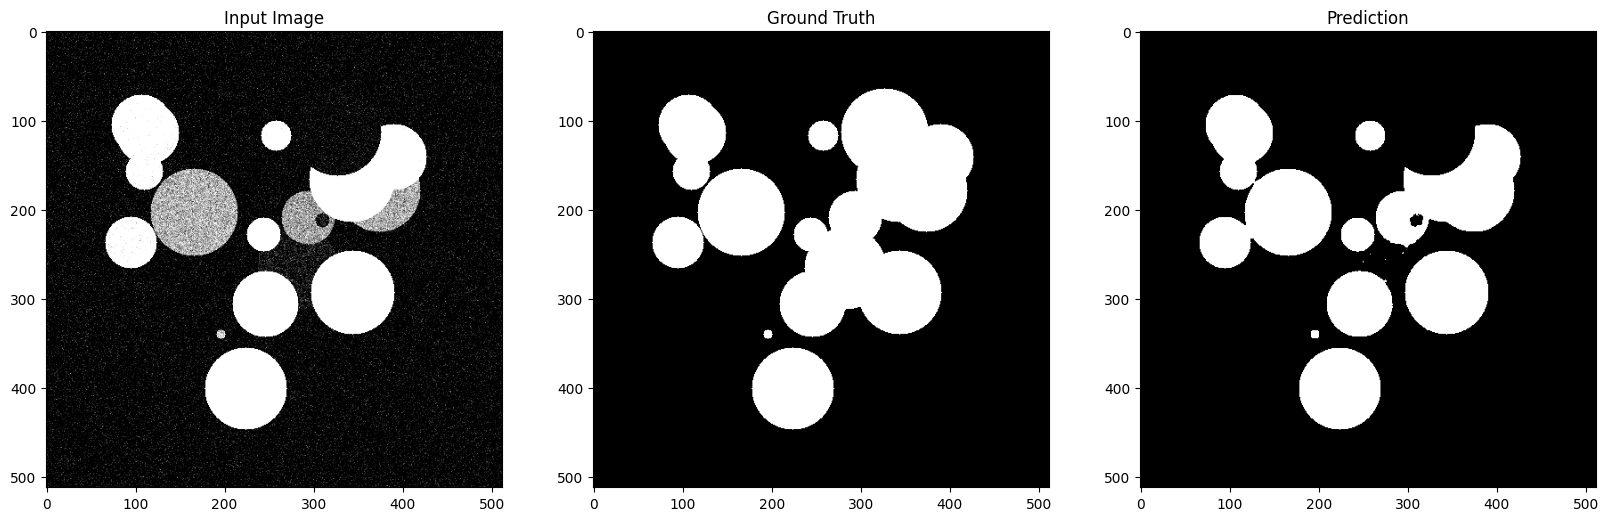

Test Loss: 0.0015, Test IoU: 0.0179, Test Dice: 0.0189


In [15]:
test_model(model, test_loader, figsize=(20, 10), device=device)

In [ ]:
results = pd.DataFrame({
    "train_loss": results[0],
    "train_iou": results[1],
    "train_dice": results[2],
    "val_loss": results[3],
    "val_iou": results[4],
    "val_dice": results[5],
}).round(4)

In [ ]:
results

,train_loss,train_iou,train_dice,val_loss,val_iou,val_dice
0,0.1154,0.8358,0.8989,0.0694,0.8947,0.9438
1,0.0802,0.8771,0.9336,0.0686,0.8940,0.9435
2,0.0992,0.8566,0.9210,0.1052,0.8335,0.9083
3,0.0778,0.8813,0.9359,0.0662,0.8970,0.9451
4,0.1061,0.8630,0.9249,0.0824,0.8739,0.9322
5,0.0789,0.8860,0.9384,0.0675,0.8967,0.9447
6,0.0768,0.8875,0.9392,0.0682,0.8967,0.9447
7,0.0761,0.8899,0.9404,0.0849,0.8866,0.9394
8,0.0758,0.8872,0.9392,0.0661,0.8977,0.9452
9,0.0736,0.8883,0.9397,0.0704,0.8994,0.9462


In [ ]:
results.to_csv("unet_results.csv")

In [18]:
torch.save(model.state_dict(), "unet_handmade.pth")